In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import gymnasium as gym
from mountain.envs.mountain import MountainEnv

In [2]:
# Load trajectories from pickle file
with open("trajectories.pickle", "rb") as f:
    trajectories = pickle.load(f)

In [3]:
def set_seed(seed=42):
    """
    Sets the random seed for NumPy, Python, and Gym for reproducibility.
    """
    np.random.seed(seed)
    random.seed(seed)

In [4]:
# Monte Carlo evaluation for vπ(s)
def mc_value_function(trajectories, gamma=0.9):
    returns = defaultdict(list)
    V = {}

    for episode in trajectories:
        G = 0
        visited_states = set()
        for t in reversed(range(len(episode))):
            state, action, reward, next_state = episode[t]
            G = gamma * G + reward
            if state not in visited_states:
                returns[state].append(G)
                visited_states.add(state)

    for state in returns:
        V[state] = np.mean(returns[state])

    return V

In [5]:
# Monte Carlo evaluation for qπ(a, s)
def mc_action_value_function(trajectories, gamma=0.9):
    returns = defaultdict(lambda: defaultdict(list))
    Q = defaultdict(lambda: defaultdict(float))

    for episode in trajectories:
        G = 0
        visited_state_actions = set()
        for t in reversed(range(len(episode))):
            state, action, reward, next_state = episode[t]
            G = gamma * G + reward
            if (state, action) not in visited_state_actions:
                returns[state][action].append(G)
                visited_state_actions.add((state, action))

    for state in returns:
        for action in returns[state]:
            Q[state][action] = np.mean(returns[state][action])

    return Q

In [6]:
# Compute the value functions
V_pi = mc_value_function(trajectories)
Q_pi = mc_action_value_function(trajectories)

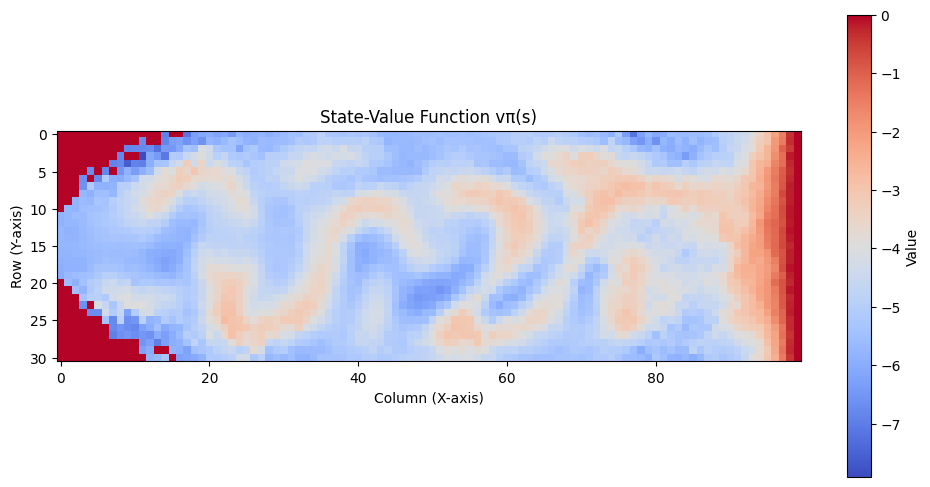

In [7]:
# Convert V_pi to a grid representation
grid_height = 31
grid_width = 100
V_grid = np.zeros((grid_height, grid_width))

for state, value in V_pi.items():
    row, col = state
    V_grid[row, col] = value

# Plot the state-value function vπ(s)
plt.figure(figsize=(12, 6))
plt.imshow(V_grid, cmap='coolwarm', origin='upper')
plt.colorbar(label="Value")
plt.title("State-Value Function vπ(s)")
plt.xlabel("Column (X-axis)")
plt.ylabel("Row (Y-axis)")
plt.show()

In [8]:
# Monte Carlo Policy Improvement: Extract the greedy policy
def mc_policy_improvement(Q):
    policy = {}

    for state in Q:
        # Choose the action with the highest value
        policy[state] = max(Q[state], key=Q[state].get)

    return policy

In [9]:
# Improve the policy
pi_prime = mc_policy_improvement(Q_pi)

In [10]:
# Compare the new policy with the old one
def is_policy_optimal(Q, pi_prime):
    for state in Q:
        best_action = max(Q[state], key=Q[state].get)
        if pi_prime[state] != best_action:
            return False  # Policy can still be improved
    return True

In [11]:
# Check if the policy is optimal
optimal = is_policy_optimal(Q_pi, pi_prime)
print(f"Is the improved policy optimal? {'Yes' if optimal else 'No'}")

Is the improved policy optimal? Yes


In [12]:
# Count how many states had a policy change
policy_changes = sum(1 for s in pi_prime if pi_prime[s] != max(Q_pi[s], key=Q_pi[s].get))
print(f"Number of states where policy changed: {policy_changes}")

Number of states where policy changed: 0


## 5 commenting on results

**MC Evaluation Result**
* The value function heatmap remained consistent with the terrain structure, indicating that the robot's movement was well-aligned with terrain difficulty.

**MC Policy Improvement Results**
* After applying MC policy improvement, 
* This suggests that the SpaceY trajectories were generated using a well-optimized policy, meaning further policy improvements were unnecessary.

**Are All Trajectories Equally Useful for MC Evaluation and Improvement?**
No, not all trajectories are equally useful. Here’s why:
1. Some Trajectories Provide More Information
    * Good trajectories (those that follow high-reward paths) are valuable because they reinforce optimal policy decisions.
    * Exploratory or suboptimal trajectories may not contribute much if they rarely visit useful states.
2. Coverage of the State Space
    * If some states are rarely visited in the given trajectories, their value estimates will be unreliable.
    * Monte Carlo methods rely on many visits to different states to get accurate estimates.
    * If trajectories don’t cover all important states, some parts of the value function may be inaccurate.
3. Finite Trajectories
    * Since the robot’s battery limits the number of steps, all trajectories are finite.
    * Some states might not be evaluated with long-term returns because episodes end early.

## 6 MC Control

In [13]:
# Environment dimensions
STATE_SPACE = (31, 100)  # 31 rows, 100 columns
ACTION_SPACE = 5  # 5 possible actions

In [14]:
def mc_control(env, gamma=0.9, episodes=20000, epsilon=0.2, alpha=0.1, threshold=0.1, policy=None):
    """
    Monte Carlo Control with Epsilon-Greedy, First-Visit MC, and Convergence Monitoring.

    Args:
        env: Gym environment instance.
        gamma: Discount factor.
        episodes: Number of episodes for evaluation.
        epsilon: Exploration rate.
        alpha: Learning rate for Q-value updates.
        threshold: Convergence threshold for policy stability.

    Returns:
        Optimal policy and action-value function.
    """
    set_seed(42)

    env.action_space.seed(42)  # Ensure Gym uses the same random seed
    env.reset(seed=42)  # Reset environment with seed

    Q = defaultdict(float)  # Q-values stored as Q[(state, action)]
    if policy is None:
        policy = defaultdict(lambda: np.random.choice(env.action_space.n))  # Default random policy
    last_policy = {}
    total_rewards = []
    average_rewards = []

    for episode in range(1, episodes + 1):
        # Reset environment and get initial state
        observation, _ = env.reset()
        state = tuple(observation['agent']['pos']) if isinstance(observation, dict) else tuple(observation)

        episode_data = []
        done = False
        total_reward = 0

        # Generate an episode by interacting with the environment
        while not done:
            # Epsilon-greedy action selection
            action = policy[state] if np.random.rand() > epsilon else np.random.choice(env.action_space.n)

            # Step through the environment
            next_obs, reward, done, _, _ = env.step(action)
            next_state = tuple(next_obs['agent']['pos']) if isinstance(next_obs, dict) else tuple(next_obs)

            # Store transition
            episode_data.append((state, action, reward))
            state = next_state
            total_reward += reward

        # First-Visit MC Evaluation: Compute Returns
        G = 0
        visited = set()

        for state, action, reward in reversed(episode_data):
            G = reward + gamma * G

            # First-visit check
            if (state, action) not in visited:
                Q[(state, action)] += alpha * (G - Q[(state, action)])
                visited.add((state, action))

        # Policy Improvement Step (Epsilon-Greedy)
        current_policy = {}
        for state, _, _ in episode_data:
            actions = [Q.get((state, a), 0) for a in range(env.action_space.n)]
            best_action = np.argmax(actions)
            current_policy[state] = best_action
            policy[state] = best_action

        total_rewards.append(total_reward)

        # Convergence Check Every 100 Episodes
        if episode % 1000 == 0:
            policy_changes = sum(1 for s in current_policy if current_policy[s] != last_policy.get(s, None))
            avg_reward = np.mean(total_rewards[-100:])
            average_rewards.append(avg_reward)
            print(f"Episode {episode}: Epsilon = {epsilon:.4f}, Policy Changes = {policy_changes}, Avg Reward = {avg_reward:.2f}")

            # Stop early if policy stabilizes
            if policy_changes / max(1, len(current_policy)) < threshold:
                print(f"\n Converged after {episode} episodes with {policy_changes} changes!")
                break

        last_policy = current_policy
        epsilon = max(0.01, 0.2 * (0.999 ** episode))  # Slower epsilon decay

    print(f"\n Final Epsilon: {epsilon}")
    print(f"Average Reward over last 500 episodes: {np.mean(total_rewards[500:]):.2f}")
    print(f"Parameters: gamma={gamma}, episodes={episodes}, epsilon={epsilon}, alpha={alpha}, threshold={threshold}")

    return policy, Q, average_rewards

In [15]:
set_seed(42)

env = MountainEnv()

# Run Monte Carlo Control
policy_env1, Q_env1, avg_rewards_env1 = mc_control(env, episodes=20000, threshold=0.1, policy=None)

Episode 1000: Epsilon = 0.0736, Policy Changes = 43, Avg Reward = -37.65
Episode 2000: Epsilon = 0.0271, Policy Changes = 16, Avg Reward = -34.71
Episode 3000: Epsilon = 0.0100, Policy Changes = 17, Avg Reward = -37.20
Episode 4000: Epsilon = 0.0100, Policy Changes = 19, Avg Reward = -35.32
Episode 5000: Epsilon = 0.0100, Policy Changes = 19, Avg Reward = -36.52
Episode 6000: Epsilon = 0.0100, Policy Changes = 16, Avg Reward = -32.55
Episode 7000: Epsilon = 0.0100, Policy Changes = 27, Avg Reward = -41.41
Episode 8000: Epsilon = 0.0100, Policy Changes = 32, Avg Reward = -32.19
Episode 9000: Epsilon = 0.0100, Policy Changes = 22, Avg Reward = -34.71
Episode 10000: Epsilon = 0.0100, Policy Changes = 24, Avg Reward = -34.87
Episode 11000: Epsilon = 0.0100, Policy Changes = 20, Avg Reward = -35.96
Episode 12000: Epsilon = 0.0100, Policy Changes = 36, Avg Reward = -35.07
Episode 13000: Epsilon = 0.0100, Policy Changes = 21, Avg Reward = -35.41
Episode 14000: Epsilon = 0.0100, Policy Changes

In [16]:
# Compare two policies to check how many states changed
def compare_policies(old_policy, new_policy):
    """
    Compare old and new policies to count how many states changed their action.
    """
    changes = np.sum(old_policy != new_policy)  # NumPy comparison
    return changes

# Compare the updated policy with the previous one
policy_changes = compare_policies(policy_env1, np.random.randint(ACTION_SPACE, size=STATE_SPACE))  # Random baseline for now
print(f"Number of states where policy changed after MC Control: {policy_changes}")

Number of states where policy changed after MC Control: 3100


In [17]:
env2 = gym.make('mountain/GridWorld-v2')
# Run Monte Carlo Control (env2)
policy_env2, Q_env2, avg_rewards_env2 = mc_control(env2, episodes=20000, threshold=0.1)

/opt/homebrew/anaconda3/envs/INF/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/opt/homebrew/anaconda3/envs/INF/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/opt/homebrew/anaconda3/envs/INF/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
/opt/homebrew/anaconda3/envs/INF/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the obser

Episode 1000: Epsilon = 0.0736, Policy Changes = 46, Avg Reward = -165.89
Episode 2000: Epsilon = 0.0271, Policy Changes = 29, Avg Reward = -157.21
Episode 3000: Epsilon = 0.0100, Policy Changes = 13, Avg Reward = -150.35
Episode 4000: Epsilon = 0.0100, Policy Changes = 28, Avg Reward = -153.25
Episode 5000: Epsilon = 0.0100, Policy Changes = 47, Avg Reward = -148.55
Episode 6000: Epsilon = 0.0100, Policy Changes = 42, Avg Reward = -146.48
Episode 7000: Epsilon = 0.0100, Policy Changes = 50, Avg Reward = -160.05
Episode 8000: Epsilon = 0.0100, Policy Changes = 58, Avg Reward = -135.40
Episode 9000: Epsilon = 0.0100, Policy Changes = 15, Avg Reward = -127.19
Episode 10000: Epsilon = 0.0100, Policy Changes = 18, Avg Reward = -116.25
Episode 11000: Epsilon = 0.0100, Policy Changes = 29, Avg Reward = -119.82
Episode 12000: Epsilon = 0.0100, Policy Changes = 64, Avg Reward = -130.87
Episode 13000: Epsilon = 0.0100, Policy Changes = 87, Avg Reward = -110.60
Episode 14000: Epsilon = 0.0100, P

In [18]:
def visualize_optimal_path(env, policy, title="Optimal Path Over Mountain Environment"):
    """
    Simulates the trained policy and overlays the path on the terrain map.
    """
    state, _ = env.reset(seed=42)  # Reset environment for consistent visualization
    state = tuple(state['agent']['pos']) if isinstance(state, dict) else tuple(state)

    path = [state]  # Track path taken
    done = False

    while not done:
        action = policy[state]  # Follow trained policy
        next_obs, _, done, _, _ = env.step(action)
        state = tuple(next_obs['agent']['pos']) if isinstance(next_obs, dict) else tuple(next_obs)
        path.append(state)

    # Extract X, Y coordinates for path
    path_x = [p[1] for p in path]  # Columns
    path_y = [p[0] for p in path]  # Rows

    # FIX: Ensure each environment uses its own map
    plt.figure(figsize=(12, 6))
    plt.imshow(env.unwrapped.MAP, cmap='terrain', origin='upper')
    plt.colorbar(label='Elevation')
    plt.plot(path_x, path_y, marker='o', color='red', markersize=3, linestyle='-', linewidth=2, label="Optimal Path")
    plt.title(title)
    plt.legend()
    plt.show()

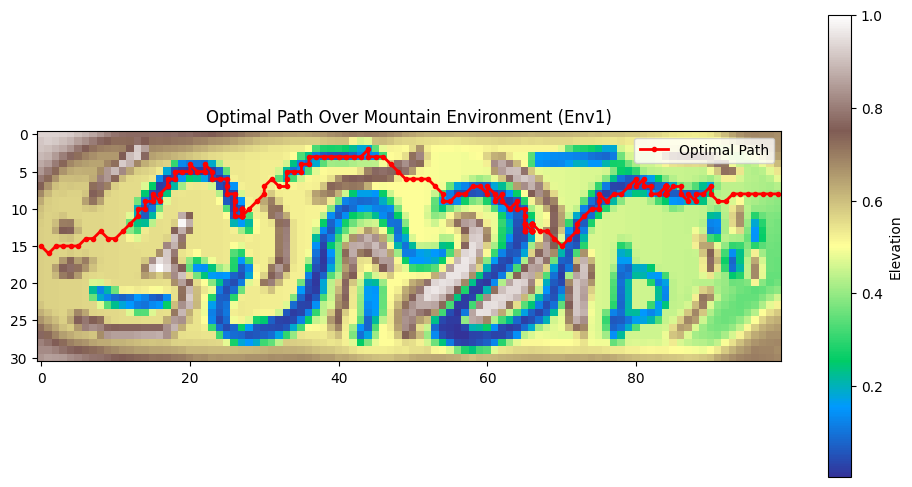

In [19]:


visualize_optimal_path(env, policy_env1, title="Optimal Path Over Mountain Environment (Env1)")

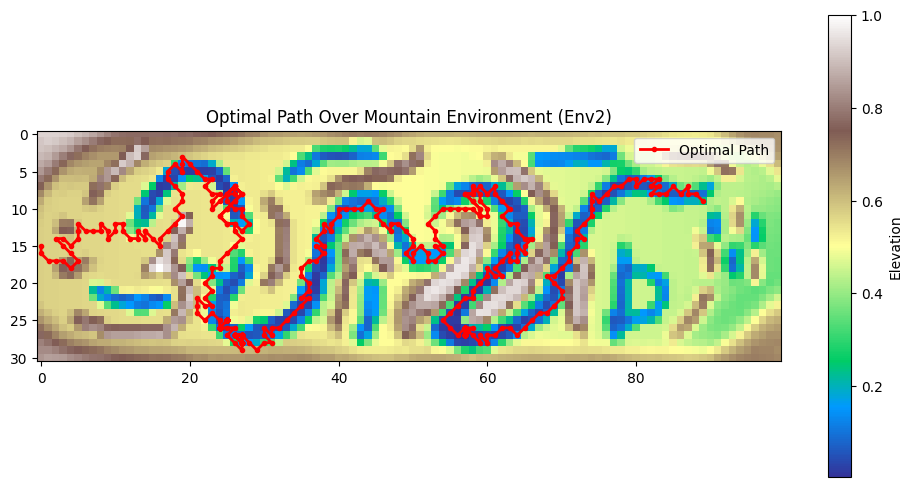

In [20]:
visualize_optimal_path(env2, policy_env2, title="Optimal Path Over Mountain Environment (Env2)")

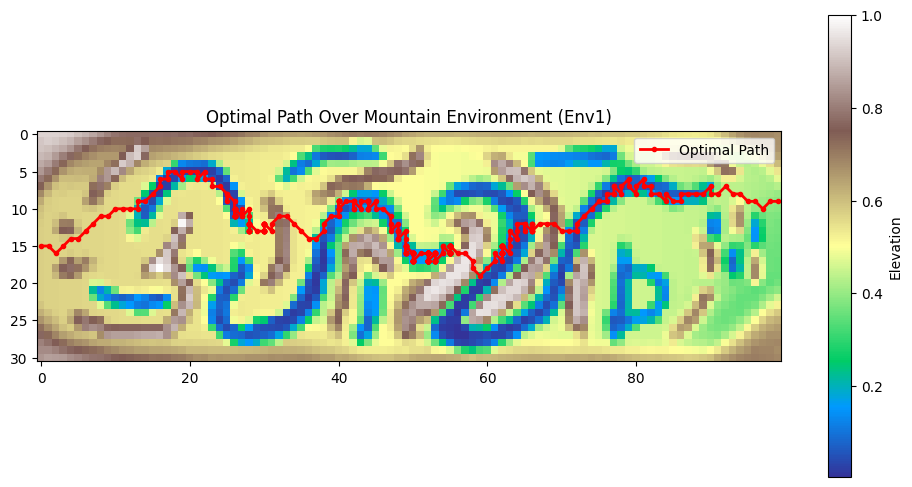

In [37]:
visualize_optimal_path(env, pi_prime, title="Optimal Path Over Mountain Environment (Env1)")

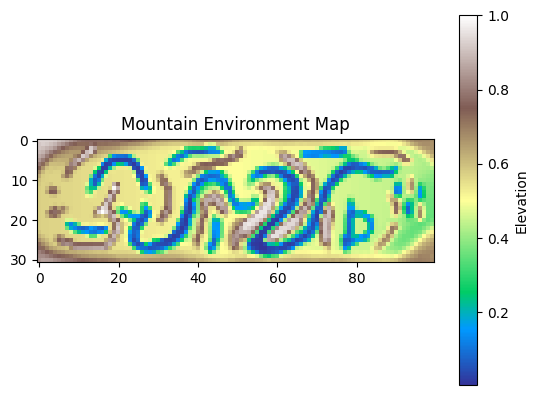

In [21]:
env = MountainEnv()
plt.imshow(env.MAP, cmap='terrain')  # Change 'terrain' to another colormap if needed
plt.colorbar(label='Elevation')
plt.title("Mountain Environment Map")
plt.show()

## 7 Starting policy
**𝜖-Greedy Policy (𝜖 = 0.2)**
* 80% of the time: Follow the best-known path (forward movement on smoother terrain).
* 20% of the time: Explore alternative routes (to avoid getting stuck).
* Why? This ensures both efficiency and adaptability

**Prioritize Forward Movement (Action 0)**
* Default action: Move right (toward the goal).
* Why? Most efficient way to reach the end.

**Allow Vertical Movement to Navigate Terrain**
* If the next forward step leads to high elevation, allow up/down movement to find a better path.

**Discourage Unnecessary Backtracking**
* Penalty for backward movement (-0.5) to prevent looping.
* Penalty for staying still (-1) to encourage continuous progress.

In [22]:
env1 = MountainEnv()
env2 = gym.make('mountain/GridWorld-v2')

In [23]:
def initialize_policy(env, epsilon=0.5):
    """
    Initializes an epsilon-greedy starting policy for the robot.
    Prioritizes forward movement but allows exploration.
    """
    policy = {}

    grid_height = 31  # Number of rows
    grid_width = 100  # Number of columns

    for row in range(grid_height):
        for col in range(grid_width):
            state = (row, col)  # Define state as (row, column)

            # Epsilon-greedy initialization
            if np.random.rand() > epsilon:
                policy[state] = 0  # Default to forward movement (Action 0)
            else:
                policy[state] = np.random.choice(env.action_space.n)  # Explore random action

    return policy


In [24]:
episodes = 30001
policy_env1 = initialize_policy(env1, epsilon=0.2)
policy_env2 = initialize_policy(env2, epsilon=0.2)

In [25]:
policy_env1, Q_env1, mc_rewards = mc_control(env1, episodes=episodes, policy=policy_env1)

policy_env2, Q_env2, mc_rewards = mc_control(env2, episodes=episodes, policy=policy_env2)

Episode 1000: Epsilon = 0.0736, Policy Changes = 70, Avg Reward = -44.40
Episode 2000: Epsilon = 0.0271, Policy Changes = 40, Avg Reward = -39.44
Episode 3000: Epsilon = 0.0100, Policy Changes = 32, Avg Reward = -37.18
Episode 4000: Epsilon = 0.0100, Policy Changes = 40, Avg Reward = -39.48
Episode 5000: Epsilon = 0.0100, Policy Changes = 25, Avg Reward = -37.58
Episode 6000: Epsilon = 0.0100, Policy Changes = 25, Avg Reward = -39.13
Episode 7000: Epsilon = 0.0100, Policy Changes = 49, Avg Reward = -41.33
Episode 8000: Epsilon = 0.0100, Policy Changes = 31, Avg Reward = -40.85
Episode 9000: Epsilon = 0.0100, Policy Changes = 23, Avg Reward = -54.21
Episode 10000: Epsilon = 0.0100, Policy Changes = 51, Avg Reward = -42.95
Episode 11000: Epsilon = 0.0100, Policy Changes = 38, Avg Reward = -43.83
Episode 12000: Epsilon = 0.0100, Policy Changes = 30, Avg Reward = -41.19
Episode 13000: Epsilon = 0.0100, Policy Changes = 28, Avg Reward = -41.26
Episode 14000: Epsilon = 0.0100, Policy Changes

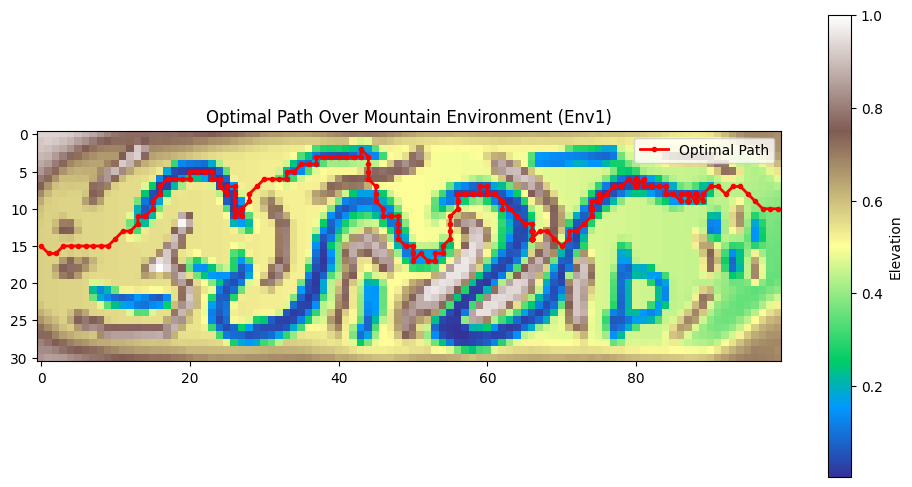

In [26]:
visualize_optimal_path(env1, policy_env1, title="Optimal Path Over Mountain Environment (Env1)")

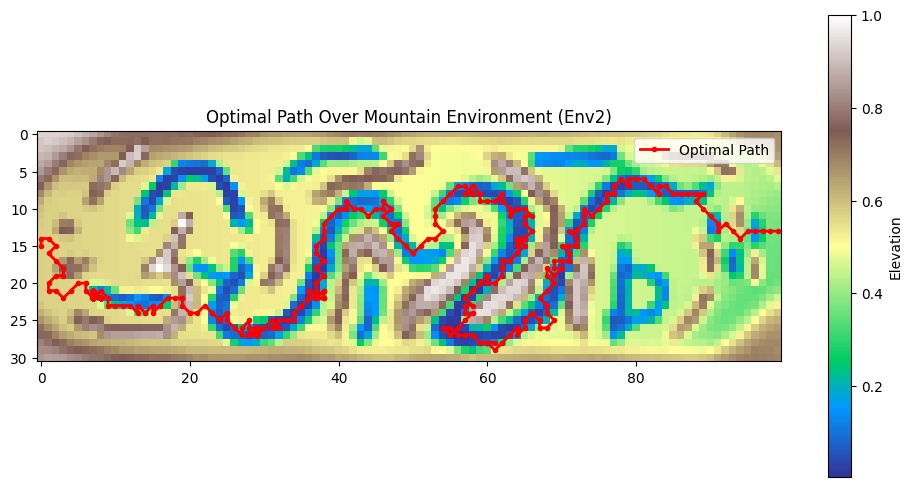

In [27]:
visualize_optimal_path(env2, policy_env2, title="Optimal Path Over Mountain Environment (Env2)")

In [28]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict


def process_state(state):
    return tuple(state["agent"]["pos"])

# SARSA(0) Algorithm
def sarsa_0(env, episodes=episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    average_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = process_state(state)  # Convert state to tuple
        action = epsilon_greedy(Q, state, epsilon)
        done = False
        total_reward = 0
        
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = process_state(next_state)  # Convert next state to tuple
            next_action = epsilon_greedy(Q, next_state, epsilon)
            
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            
            state, action = next_state, next_action
            total_reward += reward
            done = terminated or truncated
        
        rewards_per_episode.append(total_reward)
        
        if episode % 1000 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            average_rewards.append(avg_reward)
            print(f"Episode {episode}: Average Reward: {avg_reward:.2f}")
    
    return Q, average_rewards

# Epsilon-Greedy Policy
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))
    return np.argmax(Q[state])



env = gym.make('mountain/GridWorld-v2')
Q_sarsa_0, sarsa_rewards = sarsa_0(env)



Episode 0: Average Reward: -52.42
Episode 1000: Average Reward: -159.54
Episode 2000: Average Reward: -153.44
Episode 3000: Average Reward: -154.74
Episode 4000: Average Reward: -158.32
Episode 5000: Average Reward: -159.19
Episode 6000: Average Reward: -162.00
Episode 7000: Average Reward: -156.19
Episode 8000: Average Reward: -153.92
Episode 9000: Average Reward: -145.71
Episode 10000: Average Reward: -160.42
Episode 11000: Average Reward: -157.14
Episode 12000: Average Reward: -162.13
Episode 13000: Average Reward: -160.14
Episode 14000: Average Reward: -161.61
Episode 15000: Average Reward: -159.38
Episode 16000: Average Reward: -157.05
Episode 17000: Average Reward: -157.33
Episode 18000: Average Reward: -155.25
Episode 19000: Average Reward: -161.56
Episode 20000: Average Reward: -154.17
Episode 21000: Average Reward: -160.49
Episode 22000: Average Reward: -155.82
Episode 23000: Average Reward: -156.64
Episode 24000: Average Reward: -159.35
Episode 25000: Average Reward: -156.71


In [29]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict


def process_state(state):
    return tuple(state["agent"]["pos"])

# Q-learning Algorithm
def q_learning(env, episodes=episodes, alpha=0.1, gamma=0.9, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    average_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = process_state(state)
        done = False
        total_reward = 0
        
        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = process_state(next_state)
            if next_state[1] == 100:  # If agent reaches last column
                reward += 100  # Big positive reward
            
            # Q-learning update (off-policy)
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            
            state = next_state
            total_reward += reward
            done = terminated or truncated
        
        rewards_per_episode.append(total_reward)
        
        if episode % 1000 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            average_rewards.append(avg_reward)
            print(f"Episode {episode}: Average Reward: {avg_reward:.2f}")
    
    return Q, average_rewards

# Epsilon-Greedy Policy
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))
    return np.argmax(Q[state])



env = gym.make('mountain/GridWorld-v2')
Q_q_learning, q_rewards = q_learning(env)



Episode 0: Average Reward: -58.55
Episode 1000: Average Reward: -158.60
Episode 2000: Average Reward: -157.91
Episode 3000: Average Reward: -158.71
Episode 4000: Average Reward: -162.47
Episode 5000: Average Reward: -153.66
Episode 6000: Average Reward: -155.63
Episode 7000: Average Reward: -164.03
Episode 8000: Average Reward: -161.46
Episode 9000: Average Reward: -151.70
Episode 10000: Average Reward: -154.58
Episode 11000: Average Reward: -160.24
Episode 12000: Average Reward: -157.39
Episode 13000: Average Reward: -157.34
Episode 14000: Average Reward: -155.90
Episode 15000: Average Reward: -162.53
Episode 16000: Average Reward: -157.20
Episode 17000: Average Reward: -159.48
Episode 18000: Average Reward: -159.95
Episode 19000: Average Reward: -161.82
Episode 20000: Average Reward: -157.41
Episode 21000: Average Reward: -155.90
Episode 22000: Average Reward: -153.68
Episode 23000: Average Reward: -156.60
Episode 24000: Average Reward: -152.36
Episode 25000: Average Reward: -159.36


In [30]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict

# Convert state dictionary to a tuple of its array values
def process_state(state):
    return tuple(state["agent"]["pos"])

# SARSA(n) Algorithm with Fixes
def sarsa_n(env, episodes=30001, alpha=0.1, gamma=0.99, epsilon=0.1, n=10):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    average_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = process_state(state)
        action = epsilon_greedy(Q, state, epsilon)
        done = False
        total_reward = 0
        
        states, actions, rewards = [state], [action], []
        t, T = 0, float('inf')
        
        while not done:
            if t < T:
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_state = process_state(next_state)
                states.append(next_state)
                rewards.append(reward)
                
                if next_state[1] == 99:  # If agent reaches last column, give big reward and allow termination
                    
                    terminated = True
                else:
                    terminated = False  # Prevent early termination unless goal is reached
                
                if terminated or truncated:
                    T = t + 1
                else:
                    next_action = epsilon_greedy(Q, next_state, epsilon)
                    actions.append(next_action)
            
            tau = t - n + 1
            if tau >= 0:
                G = sum([gamma ** (i - tau) * rewards[i] for i in range(tau, min(tau + n, T))])
                if tau + n < T:
                    G += gamma ** n * Q[states[tau + n]][actions[tau + n]]
                Q[states[tau]][actions[tau]] += alpha * (G - Q[states[tau]][actions[tau]])
            
            if tau == T - 1:
                break
            
            state, action = next_state, next_action
            total_reward += reward
            t += 1
        
        rewards_per_episode.append(total_reward)
        epsilon = max(0.01, epsilon * 0.995)  # Epsilon decay for better exploration-exploitation
        
        if episode % 1000 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            average_rewards.append(avg_reward)
            print(f"Episode {episode}: Average Reward: {avg_reward:.2f}")
    
    return Q, sarsa_rewards

# Epsilon-Greedy Policy
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))
    return np.argmax(Q[state])


env = gym.make('mountain/GridWorld-v2')
Q_sarsa_n5, sarsan_rewards = sarsa_n(env, n=5)
Q_sarsa_n10, sarsan_rewards = sarsa_n(env, n=10)
Q_sarsa_n30, sarsan_rewards = sarsa_n(env, n=30)


Episode 0: Average Reward: -50.87
Episode 1000: Average Reward: -407.58
Episode 2000: Average Reward: -360.86
Episode 3000: Average Reward: -303.34
Episode 4000: Average Reward: -249.09
Episode 5000: Average Reward: -400.82
Episode 6000: Average Reward: -216.55
Episode 7000: Average Reward: -225.47
Episode 8000: Average Reward: -370.59
Episode 9000: Average Reward: -368.61
Episode 10000: Average Reward: -396.01
Episode 11000: Average Reward: -384.84
Episode 12000: Average Reward: -389.26
Episode 13000: Average Reward: -281.94
Episode 14000: Average Reward: -239.79
Episode 15000: Average Reward: -351.36
Episode 16000: Average Reward: -331.53
Episode 17000: Average Reward: -392.77
Episode 18000: Average Reward: -387.71
Episode 19000: Average Reward: -341.12
Episode 20000: Average Reward: -331.85
Episode 21000: Average Reward: -288.33
Episode 22000: Average Reward: -211.62
Episode 23000: Average Reward: -257.01
Episode 24000: Average Reward: -365.39
Episode 25000: Average Reward: -335.88


In [33]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict

# Convert state dictionary to a tuple of its array values
def process_state(state):
    return tuple(state["agent"]["pos"])

# SARSA(n) Algorithm with Fixes
def sarsa_n(env, episodes=30001, alpha=0.1, gamma=0.99, epsilon=0.1, n=10):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_per_episode = []
    average_rewards = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        state = process_state(state)
        action = epsilon_greedy(Q, state, epsilon)
        done = False
        total_reward = 0
        
        states, actions, rewards = [state], [action], []
        t, T = 0, float('inf')
        
        while not done:
            if t < T:
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_state = process_state(next_state)
                states.append(next_state)
                rewards.append(reward)
                
                # Ensure termination only when goal is reached
                if next_state[1] == 99:  # If agent reaches last column, give big reward
                    reward += 100
                    terminated = True
                else:
                    terminated = False  # Prevent early stopping
                
                if terminated or truncated:
                    T = t + 1
                else:
                    next_action = epsilon_greedy(Q, next_state, epsilon)
                    actions.append(next_action)
            
            tau = t - n + 1
            if tau >= 0:
                G = sum([gamma ** (i - tau) * rewards[i] for i in range(tau, min(tau + n, T))])
                if tau + n < T:
                    G += gamma ** n * Q[states[tau + n]][actions[tau + n]]
                Q[states[tau]][actions[tau]] += alpha * (G - Q[states[tau]][actions[tau]])
            
            if tau == T - 1:
                break
            
            state, action = next_state, next_action
            total_reward += reward
            t += 1

        # Ensure the episode does not terminate until the agent reaches the goal
        if state[1] != 99:
            total_reward -= 50  # Penalty for failing to reach goal

        rewards_per_episode.append(total_reward)
        epsilon = max(0.01, epsilon * 0.999)  # Slower epsilon decay
        
        if episode % 1000 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            average_rewards.append(avg_reward)
            print(f"Episode {episode}: Average Reward: {avg_reward:.2f}")
    
    return Q, average_rewards

# Epsilon-Greedy Policy
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q[state]))
    return np.argmax(Q[state])

# Initialize Environment
env = gym.make('mountain/GridWorld-v2')

# Run SARSA(n) for different values of n
Q_sarsa_n5, sarsan5_rewards = sarsa_n(env, n=5)
Q_sarsa_n10, sarsan10_rewards = sarsa_n(env, n=10)
Q_sarsa_n30, sarsan30_rewards = sarsa_n(env, n=30)


Episode 0: Average Reward: 349.23
Episode 1000: Average Reward: -470.88
Episode 2000: Average Reward: -380.30
Episode 3000: Average Reward: -464.49
Episode 4000: Average Reward: -294.97
Episode 5000: Average Reward: -355.44
Episode 6000: Average Reward: -289.85
Episode 7000: Average Reward: -432.37
Episode 8000: Average Reward: -451.87
Episode 9000: Average Reward: -388.21
Episode 10000: Average Reward: -409.64
Episode 11000: Average Reward: -436.70
Episode 12000: Average Reward: -474.04
Episode 13000: Average Reward: -295.25
Episode 14000: Average Reward: -346.04
Episode 15000: Average Reward: -458.05
Episode 16000: Average Reward: -371.55
Episode 17000: Average Reward: -420.55
Episode 18000: Average Reward: -363.75
Episode 19000: Average Reward: -92.39
Episode 20000: Average Reward: -74.75
Episode 21000: Average Reward: -361.90
Episode 22000: Average Reward: -351.38
Episode 23000: Average Reward: -269.42
Episode 24000: Average Reward: -456.33
Episode 25000: Average Reward: 242.20
Epi

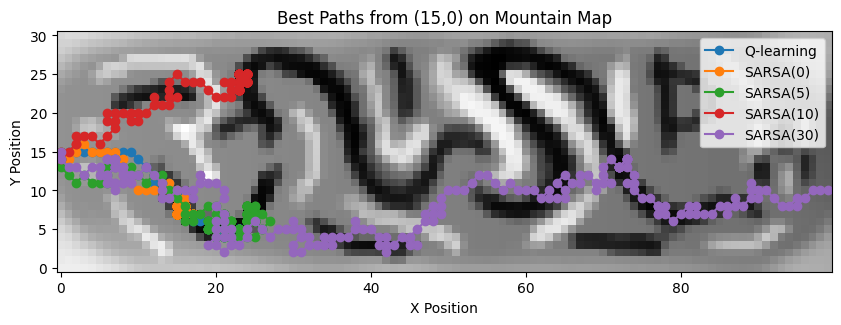

In [34]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict

# Convert state dictionary to a tuple of its array values
def process_state(state):
    return tuple(state["agent"]["pos"])

# Function to plot the best path based on Q-values
def plot_best_path(Q, env, title):
    state, _ = env.reset()
    state = process_state(state)  # Start position
    path = [state]
    
    for _ in range(1000):  # Limit steps to prevent infinite loops
        action = np.argmax(Q[state])
        next_state, _, terminated, truncated, _ = env.step(action)
        next_state = process_state(next_state)
        path.append(next_state)
        if terminated or truncated:
            break
        state = next_state
    
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], marker='o', label=title)

# Initialize Environment
env = gym.make('mountain/GridWorld-v1')

# Plot Paths for Different Q-Learning Algorithms on MAP
plt.figure(figsize=(10, 6))
plt.imshow(env.unwrapped.MAP, cmap='gray', origin='upper')  # Display the terrain map
plot_best_path(Q_q_learning, env, "Q-learning")
plot_best_path(Q_sarsa_0, env, "SARSA(0)")
plot_best_path(Q_sarsa_n5, env, "SARSA(5)")
plot_best_path(Q_sarsa_n10, env, "SARSA(10)")
plot_best_path(Q_sarsa_n30, env, "SARSA(30)")

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Best Paths from (15,0) on Mountain Map")
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for correct grid representation
plt.show()


num_points: 27
episodes length: 27
mc_rewards length: 27


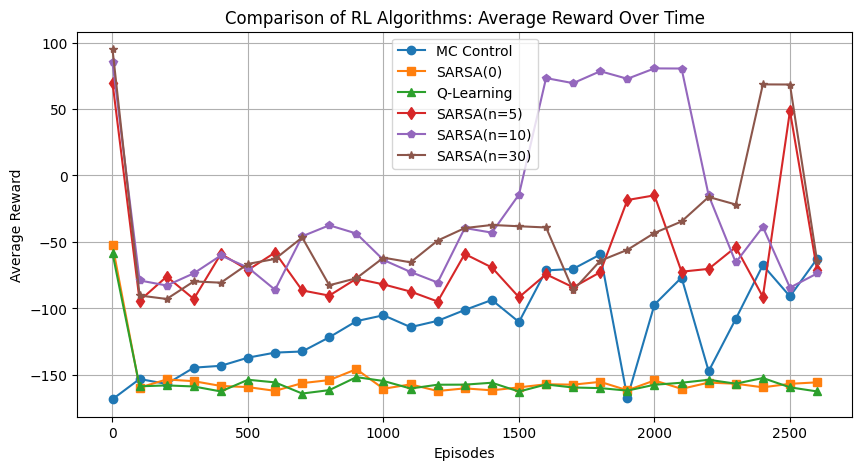

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure all lists are the same length
num_points = min(len(mc_rewards), len(sarsa_rewards), len(q_rewards),
                 len(sarsan5_rewards), len(sarsan10_rewards), len(sarsan30_rewards))

# Normalize SARSA(n) rewards
sarsan5_rewards = np.array(sarsan5_rewards[:num_points]) / 5
sarsan10_rewards = np.array(sarsan10_rewards[:num_points]) / 10
sarsan30_rewards = np.array(sarsan30_rewards[:num_points]) / 30

# Trim lists and replace NaNs with 0.0
mc_rewards = np.nan_to_num(mc_rewards[:num_points], nan=0.0)
sarsa_rewards = np.nan_to_num(sarsa_rewards[:num_points], nan=0.0)
q_rewards = np.nan_to_num(q_rewards[:num_points], nan=0.0)
sarsan5_rewards = np.nan_to_num(sarsan5_rewards, nan=0.0)
sarsan10_rewards = np.nan_to_num(sarsan10_rewards, nan=0.0)
sarsan30_rewards = np.nan_to_num(sarsan30_rewards, nan=0.0)

# Define episode range based on the actual length of the rewards lists
episodes = range(1, num_points * 100 + 1, 100)  # Adjusted range to match the reward lists

# Debugging Check
print(f"num_points: {num_points}")
print(f"episodes length: {len(list(episodes))}")
print(f"mc_rewards length: {len(mc_rewards)}")

# Plot reward curves
plt.figure(figsize=(10, 5))
plt.plot(episodes, mc_rewards, label='MC Control', linestyle='-', marker='o')
plt.plot(episodes, sarsa_rewards, label='SARSA(0)', linestyle='-', marker='s')
plt.plot(episodes, q_rewards, label='Q-Learning', linestyle='-', marker='^')
plt.plot(episodes, sarsan5_rewards, label='SARSA(n=5)', linestyle='-', marker='d')
plt.plot(episodes, sarsan10_rewards, label='SARSA(n=10)', linestyle='-', marker='p')
plt.plot(episodes, sarsan30_rewards, label='SARSA(n=30)', linestyle='-', marker='*')

# Labels and title
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.title("Comparison of RL Algorithms: Average Reward Over Time")
plt.legend()
plt.grid()

# Show the plot
plt.show()